<a href="https://colab.research.google.com/github/sebadomic/mlproject_test/blob/main/2023_04_nlp_zero_shot_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://www.caminosmadrid.es/wp-content/uploads/2020/09/mioti.jpg" width="350"  alt="MIOTI"></center>


<center style="color:#888">STATE OF THE ART IN<br/>Natural Language Processing</center>

# Challenge. Zero-shot classification en español

Utilizando el modelo de [vicgalle](https://github.com/vicgalle) que pouede encontrarse en:
https://huggingface.co/vicgalle/xlm-roberta-large-xnli-anli


El modelo base utilizado es XLM-RoBERTa:
* XLM viene de que es multilenguaje (alrededor de 100, hay una lista por ahí)
* RoBERTa es un BERT mejorado

Después, se le hace un finetunning a una tarea de NLI (Natural Language Inference), en concreto a los datasets 
* [XNLI](https://github.com/facebookresearch/XNLI): Multilingue, en concreto contiene ejemplos en español.
* [ANLI](https://github.com/facebookresearch/anli).

La clave es que cada ejemplo de NLI consiste en **dos sentencias** como inputs (premisa e hipótesis). Y es un problema de clasificación, el modelo devuelve si hay entailment o contradiction (o tres clases si se añade el neutro).

El truco es pasarle una hipótesis por cada label candidata. Por ejemplo, para un problema de análisis de sentimiento tendríamos las siguientes hipótesis:
* "Este texto es positivo"
* "Este texto es neutro"
* "Este texto es negativo"

Y luego normalizando las scores de entailment puedes sacar las probabilidades de tener concordancia con cada una de las hipótesis, siendo *de facto* el output de un problema de clasificación multi-clase si aplicamos una *softmax*.

Ejemplos de la tarea de NLI son:

<img src="https://joeddav.github.io/blog/images/zsl/nli-examples.png" width="450"  alt="examples_NLI">

Un ejemplo del dataset ANLI es:

```
{   
    "uid": "8a91e1a2-9a32-4fd9-b1b6-bd2ee2287c8f", 
    "premise": "Javier Torres (born May 14, 1988 in Artesia, California) is an undefeated Mexican American professional boxer in the Heavyweight division. 
                Torres was the second rated U.S. amateur boxer in the Super Heavyweight division and a member of the Mexican Olympic team.", 
    "hypothesis": "Javier was born in Mexico", 
    "label": "c", 
    "reason": "The paragraph states that Javier was born in the California, US."
}
```



## Instalación y configuración

Este notebook está preparado para correr en Google Colab.

In [ ]:
# instalando los paquetes necesarios
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tenso

In [ ]:
# función auxiliar para mostrar los resultados
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_context("notebook")
def plot_output(output):
    scores = output["scores"]
    colors = list(map(lambda color: sns.palettes.light_palette(color)[2],["red" if score > .5 else "blue" for score in scores]))
    plt.figure(dpi=100)
    plt.bar(output["labels"], scores, color = colors )
    plt.xlabel("Labels")
    plt.ylabel("Probability")
    plt.title(output["sequence"])
    n = list(range(len(scores)))
    for i in n:
        plt.annotate(f"{100*scores[i]:.1f}%", xy=(n[i],scores[i]*.8), ha='center', va='bottom')

    plt.show()

## Descarga e inicialización del modelo

In [ ]:
# descargamos el modelo
from transformers import pipeline
classifier = pipeline("zero-shot-classification", 
                       model="vicgalle/xlm-roberta-large-xnli-anli")

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

## Tests

In [ ]:
sequence_to_classify = "Conduce por la montaña con comodidad y estilo en el CLA Coupé. Su diseño deportivo y su ancho de vía no solo llaman la atención, sino que mejoran el dinamismo y la estabilidad."
candidate_labels = ['Mercedes', 'BMW', 'Ford']
output = classifier(sequence_to_classify, candidate_labels)

output

In [ ]:
plot_output(output)

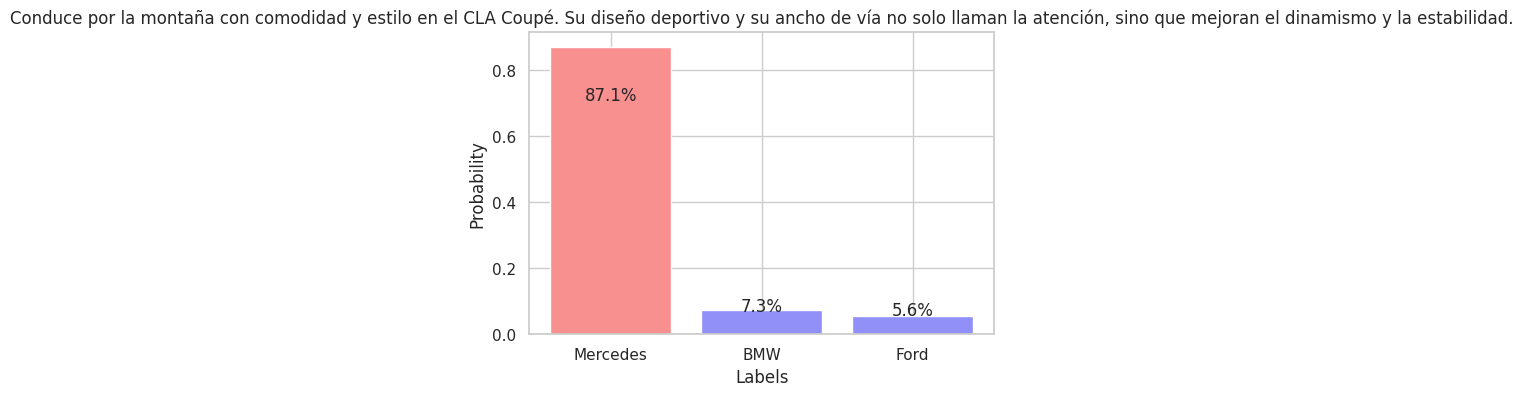

In [ ]:
sequence_to_classify = "Conduce por la montaña con comodidad y estilo en el CLA Coupé. Su diseño deportivo y su ancho de vía no solo llaman la atención, sino que mejoran el dinamismo y la estabilidad."
candidate_labels = ['Mercedes', 'BMW', 'Ford']
output = classifier(sequence_to_classify, candidate_labels)

plot_output(output)

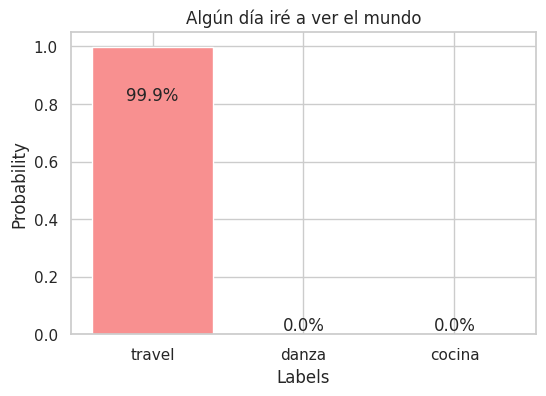

In [ ]:
sequence_to_classify = "Algún día iré a ver el mundo."
candidate_labels = ['viajes', 'danza', 'cocina']
output = classifier(sequence_to_classify, candidate_labels)

plot_output(output)

In [ ]:
sequence_to_classify = "Algún día iré a ver el mundo."
candidate_labels = ['travel', 'dance', 'cooking']
output = classifier(sequence_to_classify, candidate_labels)

plot_output(output)

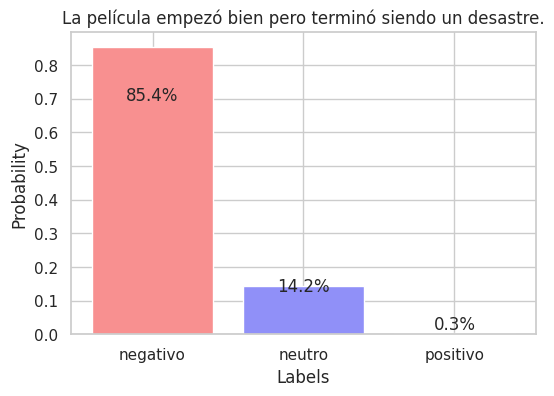

In [ ]:
sequence_to_classify = "La película empezó bien pero terminó siendo un desastre."
candidate_labels = "positivo negativo neutro".split()
output = classifier(sequence_to_classify, candidate_labels)
plot_output(output)

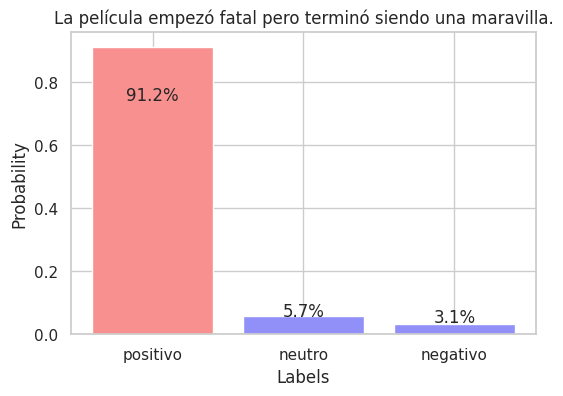

In [ ]:
sequence_to_classify = "La película empezó fatal pero terminó siendo una maravilla."
candidate_labels = "positivo negativo neutro".split()
output = classifier(sequence_to_classify, candidate_labels)
plot_output(output)

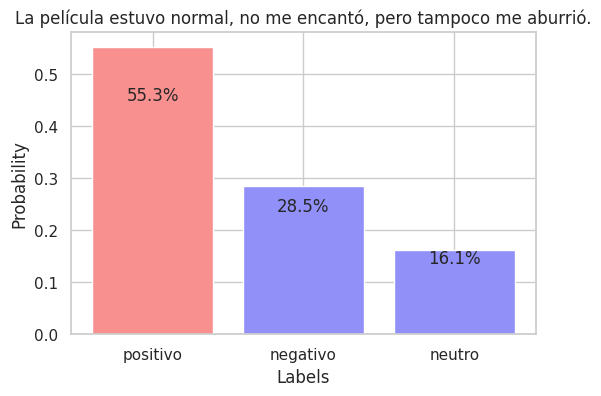

In [ ]:
sequence_to_classify = "La película estuvo normal, no me encantó, pero tampoco me aburrió."
candidate_labels = "positivo negativo neutro".split()
output = classifier(sequence_to_classify, candidate_labels)
plot_output(output)

Podemos incluso escribir las etiquetas en otro idioma (diferente al de la frase a clasificar), y las probabilidades no difieren significativamente:

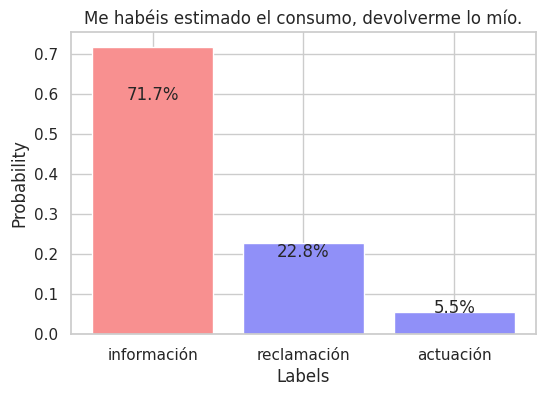

In [ ]:
sequence_to_classify = "Me habéis estimado el consumo, devolverme lo mío."
candidate_labels = "reclamación actuación información".split()
output = classifier(sequence_to_classify, candidate_labels)
plot_output(output)

Otro problema de clasificación, diferente al análisis de sentimiento sería:

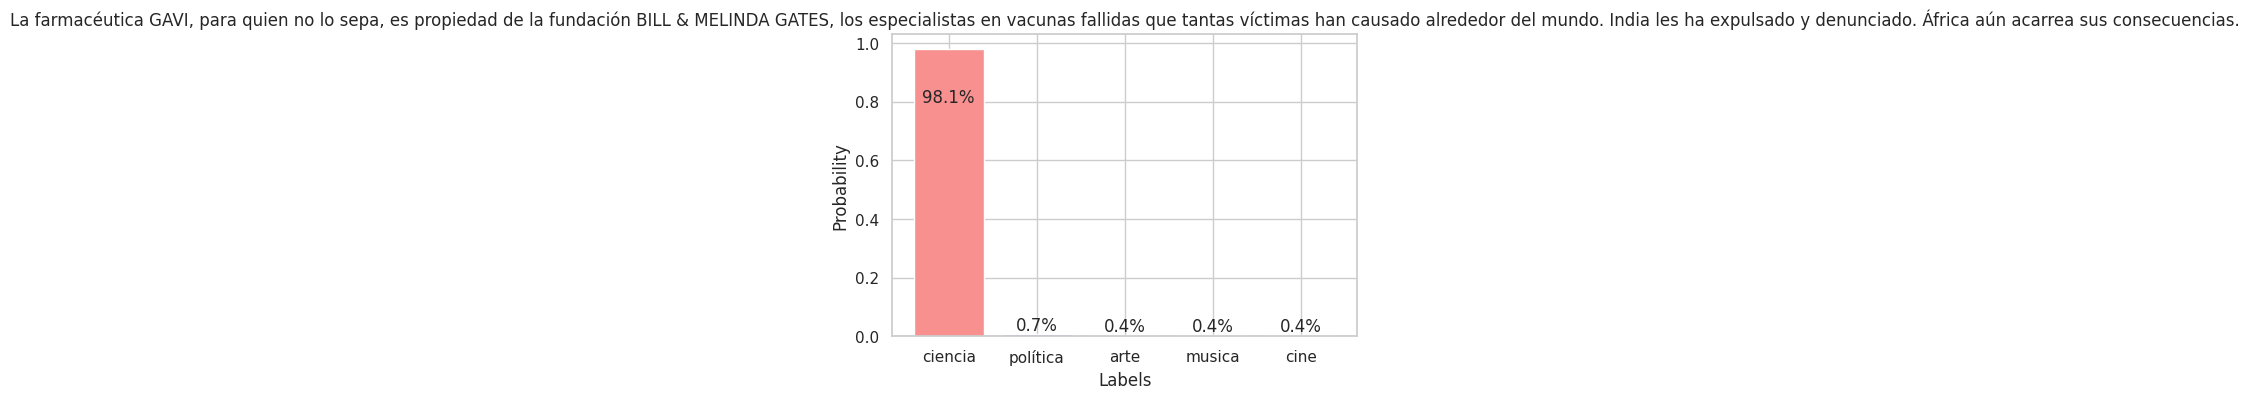

In [ ]:
# tweet de Miguel Bosé
sequence_to_classify = "La farmacéutica GAVI, para quien no lo sepa, es propiedad de la fundación BILL & MELINDA GATES, los especialistas en vacunas fallidas que tantas víctimas han causado alrededor del mundo. India les ha expulsado y denunciado. África aún acarrea sus consecuencias."
candidate_labels = "musica cine política ciencia arte".split()
output = classifier(sequence_to_classify, candidate_labels)
plot_output(output)

In [ ]:
# tweet de Miguel Bosé
sequence_to_classify = ""
candidate_labels = "".split()
output = classifier(sequence_to_classify, candidate_labels)
plot_output(output)

## Referencias Extra

* Zero Shot Learning for Text Classification [Amit Chaudhary, May 31, 2020]
https://amitness.com/2020/05/zero-shot-text-classification/

* 
https://joeddav.github.io/blog/2020/05/29/ZSL.html